In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import regex as re

# suppress data caveat warning
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
!pwd

/content


In [4]:
%cd /content/drive/MyDrive/de_project_wine_recommender/FeelFlask/backend/data_works

/content/drive/MyDrive/de_project_wine_recommender/FeelFlask/backend/data_works


In [5]:
train_data = pd.read_pickle('./preprocessed_alcohol_v4.pkl')

In [6]:
for i in range(len(train_data)):
  train_data['Ingredients'][i] = sorted(train_data['Ingredients'][i], key=lambda x : x[1])
for i in range(len(train_data)):
  train_data['Measures'][i] = sorted(train_data['Measures'][i], key=lambda x : x[1])

In [7]:
for i in range(len(train_data)):
  for j in range(len(train_data['Ingredients'][i])):
    if train_data['Ingredients'][i][j][1] != train_data['Measures'][i][j][1]:
      print("Not Sorted According Index")
print("Pass")

Pass


In [8]:
ingredient_data = train_data['Ingredients']
measurement_data = train_data['Measures']

In [9]:
ingredient_set = []
for ingredient in ingredient_data:
    for element in ingredient:
        ingredient_set.append(element[0])

unique_ingredient = np.unique(ingredient_set)
# unique_ingredient

In [10]:
# 재료 포지션 마다 위치를 고유하게 정합니다.
position_mapper = {}
for i in range(len(unique_ingredient)):
    position_mapper[unique_ingredient[i]] = i
print(position_mapper)

{'151 proof rum': 0, '7-up': 1, 'absinthe': 2, 'absolut citron': 3, 'absolut kurant': 4, 'absolut peppar': 5, 'absolut vodka': 6, 'advocaat': 7, 'agave syrup': 8, 'ale': 9, 'allspice': 10, 'almond': 11, 'almond flavoring': 12, 'amaretto': 13, 'angelica root': 14, 'angostura bitters': 15, 'anis': 16, 'anise': 17, 'anisette': 18, 'aperol': 19, 'apfelkorn': 20, 'apple': 21, 'apple brandy': 22, 'apple cider': 23, 'apple juice': 24, 'apple schnapps': 25, 'applejack': 26, 'apricot': 27, 'apricot brandy': 28, 'aquavit': 29, 'asafoetida': 30, 'añejo rum': 31, 'bacardi limon': 32, "bailey's irish cream": 33, 'baileys irish cream': 34, 'banana': 35, 'banana liqueur': 36, 'beer': 37, 'benedictine': 38, 'berries': 39, 'bitter lemon': 40, 'bitters': 41, 'black pepper': 42, 'black sambuca': 43, 'blackberry brandy': 44, 'blackcurrant cordial': 45, 'blackcurrant squash': 46, 'blended whiskey': 47, 'blue curacao': 48, 'blueberry schnapps': 49, 'bourbon': 50, 'brandy': 51, 'brown sugar': 52, 'butter': 5

In [11]:
ing_mapper = {}
index = 1
for i in range(len(unique_ingredient)):
  ing_mapper[unique_ingredient[i]] = index
  index += 1

In [12]:
col = len(unique_ingredient)
row = len(ingredient_data)
embedding = np.zeros((row, col))
embedding.shape

(546, 308)

In [13]:
ingredient_embedding = []
for row in range(len(train_data)):
  element = train_data['Ingredients'][row]
  item_list = []
  for item in range(len(element)):
    item_list.append(ing_mapper[element[item][0]])
  ingredient_embedding.append(item_list)

In [14]:
from tensorflow.keras.utils import pad_sequences
ingredient_embedding = pad_sequences(ingredient_embedding, padding='post')
ingredient_embedding

array([[108, 293,   0, ...,   0,   0,   0],
       [  5, 148,  68, ...,   0,   0,   0],
       [178, 282,   0, ...,   0,   0,   0],
       ...,
       [ 38, 252, 185, ...,   0,   0,   0],
       [293, 222,   0, ...,   0,   0,   0],
       [257,  34, 299, ...,   0,   0,   0]], dtype=int32)

In [15]:
# 해당 embedding은 position은 ingredient의 정보를, value는 measurement양의 정보를 가지고 있습니다.
for i in range(len(ingredient_data)): # 각 row 데이터 마다
    for j in range(len(ingredient_data[i])): # 각 column 데이터 마다
        # embedding[i][position_mapper[ingredient_data[i][j][0]]] = measurement_data[i][j][0]
        embedding[i][position_mapper[ingredient_data[i][j][0]]] = 1 # 재료의 사용 여부를 표기한 임베딩

# embedding numpy array는 재료의 사용여부를 1, 0으로 표현한 벡터의 집합입니다. (546x306)

In [16]:
with open("../flavor.json", "r") as fr:
  flavor_info = json.load(fr)
# flavor_info

In [17]:
def find_index(name):
  for i in range(len(flavor_info)):
    if name == flavor_info[i]['name']:
      return i
  print("Non Exist Ingredients!")
  print(name)
  return None

def delete_ap(name):
  name = re.sub('\'', '', name)
  return name

index = find_index('7-up')
flavor_info[index]['name']

'7-up'

In [18]:
# 해당 anis pernod 술은 chatgpt에 프롬프팅해서 값을 대략적으로 알아냈습니다.
anis = {'name' : 'anis', 'ABV' : 40, 'boozy' : 60, 'sweet':75, 'sour':5, 'bitter':15, 'umami':5, 'salty':5, 'astringent':15, 'Perceived_temperature':20, 'spicy':40, 'herbal' : 85, 'floral' : 20, 'fruity' : 10, 'nutty':5, 'creamy':5, 'smoky':5}
flavor_info.append(anis)

with open('../flavor_update.json', 'w') as fw:
  json.dump(flavor_info, fw)

with open('../flavor_update.json', 'r') as fr:
  flavor_info = json.load(fr)

In [19]:
# making label data -> 546x16 -> 546개의 결과에 대해 16개의 값들을 각각 예측합니다.
# 라벨을 만드는 방법은, 사용한 재료들의 특성들을 모두 합하여 만들어 냅니다. (선형적으로 맛의 특성이 증가한다고 가정합니다.)
# 확인해 보면 anis라는 재료의 이름이 없어 오류가 나는 것을 알 수 있습니다. (index 318, 508, 510)
# flavor.json 파일이 anis라는 술의 이름을 포함하도록 수정되어야 합니다.

feature_list = ['ABV', 'boozy', 'sweet', 'sour', 'bitter', 'umami', 'salty', 'astringent', 'Perceived_temperature', 'spicy', 'herbal',
                'floral', 'fruity', 'nutty', 'creamy', 'smoky']

label = np.zeros((546, len(feature_list)))

for i in range(len(train_data['Ingredients'])):
  ingredient_name = []
  for ingredient in train_data['Ingredients'][i]:
    ingredient_name.append(delete_ap(ingredient[0]))
  for name_index in range(len(ingredient_name)):
    index = find_index(ingredient_name[name_index])
    for feature_index in range(len(feature_list)):
      try:
        label[i][feature_index] += flavor_info[index][feature_list[feature_index]] * train_data['Measures'][i][name_index][0] # label에 flavor_info의 각각 16개의 특성(name은 제외)
      except TypeError:
        print("Index of ingredients: ", i)

In [20]:
feature_label = []
for i in range(len(feature_list)):
  feature_label.append([]) # 16개 특성 마다 각각의 feature를 담기 위한 배열을 만들어둡니다.

for row_index in range(len(label)):
  for feature_index in range(len(label[row_index])):
    feature_label[feature_index].append(label[row_index][feature_index])

In [21]:
measurement_label = np.zeros((546, 308))
for i in range(len(train_data)):
  for j in range(len(train_data['Measures'][i])):
    measurement_label[i][position_mapper[train_data['Ingredients'][i][j][0]]] = train_data['Measures'][i][j][0]

In [22]:
for feature_index in range(len(feature_label)):
  feature_label[feature_index] = np.array(feature_label[feature_index]).reshape(546, -1)

In [23]:
measurement_data=[]
for i in range(len(train_data)):
  measure_list = []
  for j in range(len(train_data['Measures'][i])):
    measure_list.append(train_data['Measures'][i][j][0])
  measurement_data.append(measure_list)

In [25]:
# pad_sequences는 정수만 반환함으로 실수를 사용할 수 있도록 해야 합니다.
# 그렇지 않으면 0.3과 같은 값들은 모조리 0이 되어 버립니다.
# measurement_embedding = pad_sequences(measurement_data, padding='post')

for i in range(len(measurement_data)):
  element = measurement_data[i]
  for index in range(12-len(element)):
    measurement_data[i].append(0)



measurement_embedding = measurement_data

In [33]:
np.shape(measurement_embedding)
measurement_embedding = np.array(measurement_embedding)

In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Embedding, Flatten, Embedding, BatchNormalization, Dropout, ReLU, Add, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses import Loss
from sklearn.model_selection import train_test_split

In [ ]:
# train_data, val_data, train_label, val_label = train_test_split(embedding, label, test_size=0.1, random_state=150)
emb_train, emb_val, train_label, val_label = train_test_split(ingredient_embedding, label, test_size=0.1, random_state=150)

In [ ]:
ingr_input = Input(shape=(12, ))
# meas_input = Input(shape=(12, ))

pre1 = Embedding(308, 128)(ingr_input) # 12 * 128
flatten = Flatten()(pre1)

# mea_pre1 = Dense(64)(meas_input)
# mea_x = BatchNormalization()(mea_pre1)
# mea_x = ReLU()(mea_x)
# mea_pre2 = Dense(128)(mea_x)
# mea_x = BatchNormalization()(mea_pre2)
# mea_x = ReLU()(mea_x)
# concat_l = Concatenate()([flatten, mea_x]) # 768 * 2

hidden0 = Dense(1024)(flatten)
x = BatchNormalization()(hidden0)
x = ReLU()(x)

hidden1 = Dense(768)(x)
x = BatchNormalization()(hidden1)
x = ReLU()(x)
hidden2 = Dense(384)(x)
x = BatchNormalization()(hidden2)
x = ReLU()(x)
hidden3 = Dense(192)(x)
x = BatchNormalization()(hidden3)
x = ReLU()(x)
hidden4 = Dense(96)(x)
x = BatchNormalization()(hidden4)
x = ReLU()(x)
hidden5 = Dense(64)(x)
x = BatchNormalization()(hidden5)
x = ReLU()(x)
hidden6 = Dense(32)(x)
x = BatchNormalization()(hidden6)
x = ReLU()(x)
hidden7 = Dense(16)(x)
x = BatchNormalization()(hidden7)
x = ReLU()(x)
hidden8 = Dense(32)(x)
res1 = Add()([hidden8, hidden6])
x = BatchNormalization()(res1)
x = ReLU()(x)
hidden9 = Dense(64)(x)
res2 = Add()([hidden9, hidden5])
x = BatchNormalization()(res2)
x = ReLU()(x)
hidden10 = Dense(96)(x)
res3 = Add()([hidden10, hidden4])
x = BatchNormalization()(res3)
x = ReLU()(x)
hidden11 = Dense(192)(x)
res4 = Add()([hidden11, hidden3])
x = BatchNormalization()(res4)
x = ReLU()(x)
hidden12 = Dense(384)(x)
res5 = Add()([hidden12, hidden2])
x = BatchNormalization()(res5)
x = ReLU()(x)

output = Dense(16)(x)

ing_to_feature = Model(inputs=ingr_input, outputs=output, name='ingredient_to_feature')
optimizer = Adam(learning_rate=0.01)
ing_to_feature.compile(optimizer=optimizer, loss='mae')

In [ ]:
# 한꺼번에 훈련시키는 경우
epochs = 500
batch_size=546
# 해당 모델은 입력을 바탕으로, 각 술의 특성 값들을 예측해 내는 일을 수행합니다.
ing_to_feature.fit(ingredient_embedding, label, epochs=epochs, batch_size=batch_size) # 재료 사용여부 -> 각 술의 측성 (measurement 값 반영)
# ing_to_feature.fit(emb_data, train_label, epochs=epochs, batch_size=batch_size, validation_data=(emb_val, val_label))

In [ ]:
ing_to_feature.save('./checkpoint/ing_to_features.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# emb_train, emb_val, measure_train_label, measure_val_label = train_test_split(embedding, measurement_label, test_size=0.1, random_state=150)
measure_train, measure_val, measure_train_label, measure_val_label = train_test_split(ingredient_embedding, measurement_label, test_size=0.1, random_state=150)

In [ ]:
input = Input(shape=(12, ))

pre1 = Embedding(308, 64)(input)
flatten = Flatten()(pre1)

pre2 = Dense(512)(flatten)
x = BatchNormalization()(pre2)
x = ReLU()(x)

pre3 = Dense(256)(x)
x = BatchNormalization()(pre3)
x = ReLU()(x)

pre4 = Dense(128)(x)
x = BatchNormalization()(pre4)
x = ReLU()(x)

hidden1 = Dense(64)(x)
x = BatchNormalization()(hidden1)
x = ReLU()(x)

hidden2 = Dense(32)(x)
x = BatchNormalization()(hidden2)
x = ReLU()(x)

hidden3 = Dense(16)(x)
x = BatchNormalization()(hidden3)
x = ReLU()(x)

hidden4 = Dense(8)(x)
x = BatchNormalization()(hidden4)
x = ReLU()(x)

residual = Dense(16)(x)
hidden5 = Add()([hidden3, residual])
x = BatchNormalization()(hidden5)
x = ReLU()(x)

residual2 = Dense(32)(x)
hidden6 = Add()([hidden2, residual2])
x = BatchNormalization()(hidden6)
x = ReLU()(x)

residual3 = Dense(64)(x)
hidden7 = Add()([hidden1, residual3])
x = BatchNormalization()(hidden7)
x = ReLU()(x)

hidden8 = Dense(128)(x)
hidden8 = Add()([hidden8, pre4])
x = BatchNormalization()(hidden8)
x = ReLU()(x)

hidden9 = Dense(256)(x)
hidden9 = Add()([hidden9, pre3])
x = BatchNormalization()(hidden9)
x = ReLU()(x)

hidden10 = Dense(512)(x)
hidden10 = Add()([hidden10, pre2])
x = BatchNormalization()(hidden10)
x = ReLU()(x)
cls_output = Dense(308, activation='sigmoid')(x)
reg_output = Dense(12)(x) # 12개 이상의 재료를 갖는 경우는 없음으로


ing_to_measure = Model(inputs=input, outputs=[cls_output, reg_output], name='ingredient_to_measurement')
optimizer = Adam(learning_rate=0.001)
ing_to_measure.compile(optimizer=optimizer, loss=['binary_crossentropy', 'mae'])

In [ ]:
epochs= 1000
batch_size=546

ing_to_measure.fit(ingredient_embedding, [embedding, measurement_label], epochs=epochs, batch_size=batch_size) # 재료 사용여부 -> 각 재료의 사용량 (재료에 따른 사용량 예측)
# ing_to_measure.fit(measure_train, measure_train_label, epochs=epochs, batch_size=batch_size, validation_data=(measure_val, measure_val_label)) # 재료 사용여부 -> 각 재료의 사용량 (재료에 따른 사용량 예측)


Epoch 1/1000
1/1 [==============================] - 8s 8s/step - loss: 1.8114
Epoch 2/1000
1/1 [==============================] - 0s 99ms/step - loss: 1.7648
Epoch 3/1000
1/1 [==============================] - 0s 108ms/step - loss: 1.7193
Epoch 4/1000
1/1 [==============================] - 0s 97ms/step - loss: 1.6748
Epoch 5/1000
1/1 [==============================] - 0s 102ms/step - loss: 1.6321
Epoch 6/1000
1/1 [==============================] - 0s 98ms/step - loss: 1.5918
Epoch 7/1000
1/1 [==============================] - 0s 99ms/step - loss: 1.5544
Epoch 8/1000
1/1 [==============================] - 0s 95ms/step - loss: 1.5204
Epoch 9/1000
1/1 [==============================] - 0s 95ms/step - loss: 1.4900
Epoch 10/1000
1/1 [==============================] - 0s 97ms/step - loss: 1.4634
Epoch 11/1000
1/1 [==============================] - 0s 96ms/step - loss: 1.4404
Epoch 12/1000
1/1 [==============================] - 0s 92ms/step - loss: 1.4209
Epoch 13/1000
1/1 [==================

KeyboardInterrupt: 

In [ ]:
ing_to_measure.save('./checkpoint/ing_to_measure.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
position_mapper
position_to_ing = {value: key for key, value in position_mapper.items()}

In [ ]:
def decode(array, name_list, ingredient_length = 5):
  row, col = array.shape
  prediction = []
  for i in range(row):
    prediction.append({})

    for j in range(col):
      if array[i][j] > 0:
        prediction[i][position_to_ing[j]] = array[i][j]

  for recipe_index in range(len(prediction)):
    prediction[recipe_index] = sorted(prediction[recipe_index].items(), key=lambda x: x[1], reverse=True)

  output = []
  for recipe_index in range(len(prediction)):
    output.append(prediction[recipe_index][0:ingredient_length])
  for output_index in range(len(output)):
    output[output_index].append(('name', name_list[output_index]))
  return output

In [ ]:
drink_name = train_data['DrinkName'][0:3].to_list()
result = ing_to_measure.predict(ingredient_embedding[0:3], batch_size=3)
prediction = decode(result, drink_name)

1/1 [==============================] - 2s 2s/step


In [ ]:
prediction

[[('cherry liqueur', 0.0037476406),
  ('light cream', 0.0029181303),
  ('water', 0.002768871),
  ('beer', 0.0023239907),
  ('cranberry vodka', 0.0023192698),
  ('name', "'57 Chevy with a White License Plate")],
 [('water', 0.04121747),
  ('vodka', 0.0054766475),
  ('ginger', 0.0041144057),
  ('midori melon liqueur', 0.0038821306),
  ('erin cream', 0.0038329451),
  ('name', '1-900-FUK-MEUP')],
 [('cherry liqueur', 0.0029446618),
  ('water', 0.0025930759),
  ('tea', 0.0025078957),
  ('coconut syrup', 0.0023053735),
  ('light cream', 0.0022785417),
  ('name', '110 in the shade')]]

In [ ]:
class SparseRegressionLoss(Loss):
  # labels을 미리 입력받아, label에 값이 0으로 sparse하다면 더 적은 가중치를 부여하고
  # 사용된 재료에 대해서 발생하는 loss에 대해서는 큰 가중치를 부여하는 loss입니다.
  def __init__(self, sparse_coeff):
    super().__init__()
    self.coef = sparse_coeff

  def call(self, y_true, y_pred):
    mask = y_pred==0
    main_mask = y_true==1

    sparse_num = len(mask)
    main_num = len(main_mask)

    sparse_loss = tf.math.abs(y_true[mask] - y_pred[mask]) * self.coef
    main_loss = tf.math.abs(y_true[main_mask] - y_pred[main_mask]) * (1/self.coef)

    loss = tf.math.reduce_sum(sparse_loss)/sparse_num + tf.math.reduce_sum(main_loss)/main_num
    return loss

In [ ]:
input = Input(shape=(308, ))

pre2 = Dense(512)(input)
x = BatchNormalization()(pre2)
x = ReLU()(x)

pre3 = Dense(256)(x)
x = BatchNormalization()(pre3)
x = ReLU()(x)

pre4 = Dense(128)(x)
x = BatchNormalization()(pre4)
x = ReLU()(x)

hidden1 = Dense(64)(x)
x = BatchNormalization()(hidden1)
x = ReLU()(x)

hidden2 = Dense(32)(x)
x = BatchNormalization()(hidden2)
x = ReLU()(x)

hidden3 = Dense(16)(x)
x = BatchNormalization()(hidden3)
x = ReLU()(x)

hidden4 = Dense(8)(x)
x = BatchNormalization()(hidden4)
x = ReLU()(x)

residual = Dense(16)(x)
hidden5 = Add()([hidden3, residual])
x = BatchNormalization()(hidden5)
x = ReLU()(x)

residual2 = Dense(32)(x)
hidden6 = Add()([hidden2, residual2])
x = BatchNormalization()(hidden6)
x = ReLU()(x)

residual3 = Dense(64)(x)
hidden7 = Add()([hidden1, residual3])
x = BatchNormalization()(hidden7)
x = ReLU()(x)

hidden8 = Dense(128)(x)
hidden8 = Add()([hidden8, pre4])
x = BatchNormalization()(hidden8)
x = ReLU()(x)

hidden9 = Dense(256)(x)
hidden9 = Add()([hidden9, pre3])
x = BatchNormalization()(hidden9)
x = ReLU()(x)

hidden10 = Dense(512)(x)
hidden10 = Add()([hidden10, pre2])
x = BatchNormalization()(hidden10)
x = ReLU()(x)
output = Dense(308)(x)

custom_loss = SparseRegressionLoss(0.75)

embedding_model = Model(inputs=input, outputs=output, name='ingredient_to_measurement')
optimizer = Adam(learning_rate=0.001)
embedding_model.compile(optimizer=optimizer, loss=custom_loss)

In [ ]:
# embedding.shape
# measurement_label.shape

(546, 308)

In [ ]:
epochs= 1000
batch_size=546
embedding_model.fit(embedding, measurement_label, epochs=epochs, batch_size=batch_size)

In [ ]:
result = embedding_model.predict(embedding[0:3])
drink_name = train_data['DrinkName'][0:3].to_list()
prediction = decode(result, drink_name)
prediction

1/1 [==============================] - 0s 381ms/step


In [ ]:
# ingredient_embedding은 각 술 재료당 사용된 재료를 고유하게 부여된 정수 숫자 값으로 맵핑한 것입니다.
ingredient_embedding
# measurement_embedding은 각 술에 사용된 재료의 양에 관한 정보를 가지고 있습니다. 가장 다양한 재료가 들어간 경우는
# 12개의 재료가 들어간 경우이기 때문에, 12개를 최대로 padding하였습니다. 이를 라벨로 사용할 것입니다.
measurement_embedding

array([[ 29,  29,   0, ...,   0,   0,   0],
       [ 14,   7,   7, ...,   0,   0,   0],
       [473,  44,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [ 36,   7,   0, ...,   0,   0,   0],
       [ 20,  20,  20, ...,   0,   0,   0]], dtype=int32)

In [ ]:
train_data, val_data, train_label, val_label = train_test_split(ingredient_embedding, measurement_embedding, test_size=0.1, random_state=1)

In [34]:
# ingredient_embedding의 경우, 어떤 재료가 사용되는 지에 관한 정보를 가지고 있음으로, 이를 embedding layer로
# 투영하여 훈련할 것입니다. 이때 dictionary의 크기는 사용된 고유한 재료는 309개가 되어야 합니다. (padding포함)
def create_dnn_network(model_name, embedding_dim=16):
  input = tf.keras.layers.Input(shape=(12, ))
  embed = tf.keras.layers.Embedding(309, embedding_dim)(input)
  flatten = tf.keras.layers.Flatten()(embed)

  x = tf.keras.layers.Dense(12*embedding_dim)(flatten)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.Dropout(0.25)(x)

  x = tf.keras.layers.Dense(244)(x)
  x = tf.keras.layers.ReLU()(x)

  output = tf.keras.layers.Dense(12)(x)

  model = tf.keras.Model(inputs=input, outputs=output, name=model_name)
  return model

model = create_dnn_network('Little_Sparse_Vector')

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mae', metrics=['accuracy'])


In [35]:
EPOCHS=2000
BATCH_SIZE=546
history = model.fit(ingredient_embedding, measurement_embedding, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/2000
1/1 [==============================] - 1s 753ms/step - loss: 34.0985 - accuracy: 0.1099
Epoch 2/2000
1/1 [==============================] - 0s 31ms/step - loss: 34.0894 - accuracy: 0.1410
Epoch 3/2000
1/1 [==============================] - 0s 19ms/step - loss: 34.0819 - accuracy: 0.1758
Epoch 4/2000
1/1 [==============================] - 0s 19ms/step - loss: 34.0758 - accuracy: 0.1703
Epoch 5/2000
1/1 [==============================] - 0s 18ms/step - loss: 34.0684 - accuracy: 0.1630
Epoch 6/2000
1/1 [==============================] - 0s 20ms/step - loss: 34.0609 - accuracy: 0.1832
Epoch 7/2000
1/1 [==============================] - 0s 20ms/step - loss: 34.0519 - accuracy: 0.1832
Epoch 8/2000
1/1 [==============================] - 0s 23ms/step - loss: 34.0411 - accuracy: 0.1923
Epoch 9/2000
1/1 [==============================] - 0s 19ms/step - loss: 34.0269 - accuracy: 0.2143
Epoch 10/2000
1/1 [==============================] - 0s 19ms/step - loss: 34.0110 - accuracy: 0.234

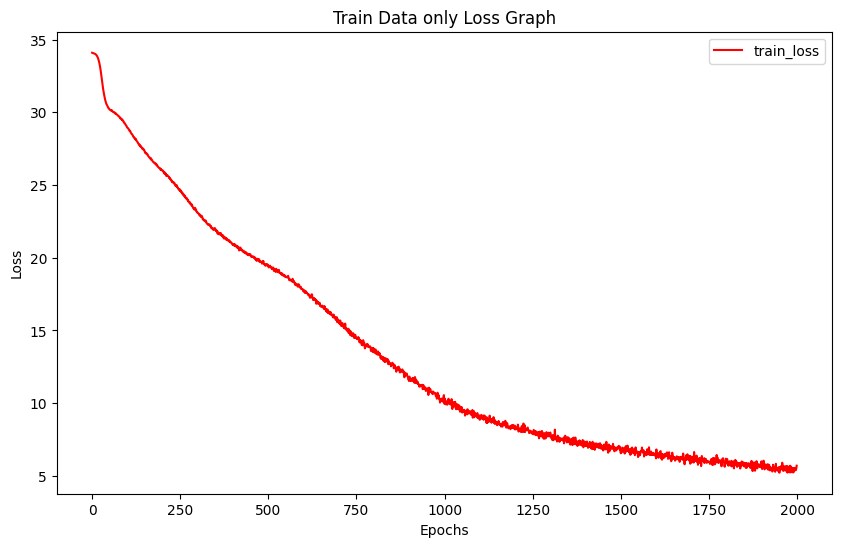

In [36]:
# 훈련 loss 값 변화
train_loss = history.history['loss']
plt.figure(figsize=(10, 6))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Data only Loss Graph')
plt.plot(range(EPOCHS), train_loss, color='r', label='train_loss')
plt.legend()

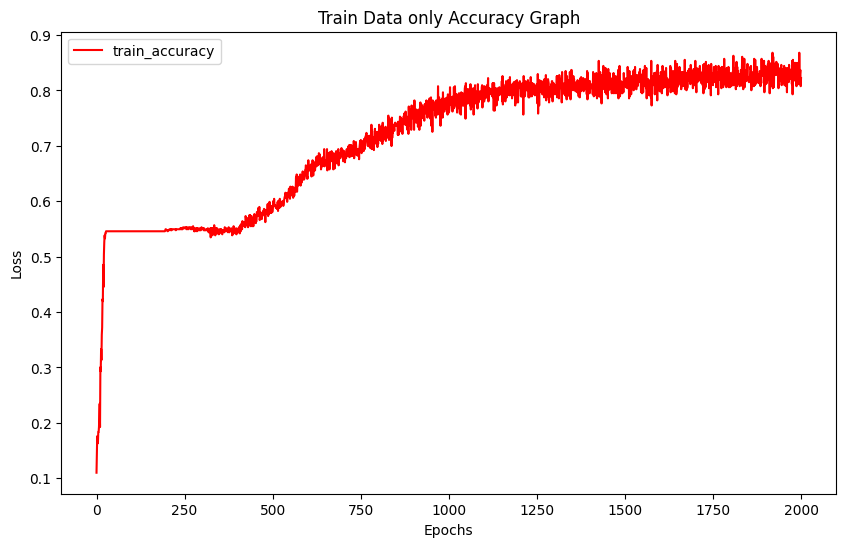

In [37]:
# 훈련 loss 값 변화
train_acc = history.history['accuracy']
plt.figure(figsize=(10, 6))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Data only Accuracy Graph')
plt.plot(range(EPOCHS), train_acc, color='r', label='train_accuracy')
plt.legend()

In [ ]:
# 모델이 제대로 일반화가 되고 있는가? 실험해 봅니다.
model_w_val = create_dnn_network('Little_Sparse_Vector_with_val')

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model_w_val.compile(optimizer=optimizer, loss='mae', metrics=['accuracy'])
history = model_w_val.fit(train_data, train_label, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(val_data, val_label))

Epoch 1/2000
1/1 [==============================] - 1s 1s/step - loss: 35.3376 - accuracy: 0.0876 - val_loss: 21.8558 - val_accuracy: 0.4182
Epoch 2/2000
1/1 [==============================] - 0s 44ms/step - loss: 35.3236 - accuracy: 0.3870 - val_loss: 21.8438 - val_accuracy: 0.4364
Epoch 3/2000
1/1 [==============================] - 0s 64ms/step - loss: 35.3131 - accuracy: 0.4358 - val_loss: 21.8331 - val_accuracy: 0.4727
Epoch 4/2000
1/1 [==============================] - 0s 53ms/step - loss: 35.3021 - accuracy: 0.4766 - val_loss: 21.8199 - val_accuracy: 0.3818
Epoch 5/2000
1/1 [==============================] - 0s 74ms/step - loss: 35.2899 - accuracy: 0.4094 - val_loss: 21.8050 - val_accuracy: 0.4364
Epoch 6/2000
1/1 [==============================] - 0s 52ms/step - loss: 35.2750 - accuracy: 0.4420 - val_loss: 21.7849 - val_accuracy: 0.2545
Epoch 7/2000
1/1 [==============================] - 0s 63ms/step - loss: 35.2558 - accuracy: 0.3707 - val_loss: 21.7612 - val_accuracy: 0.4000
E

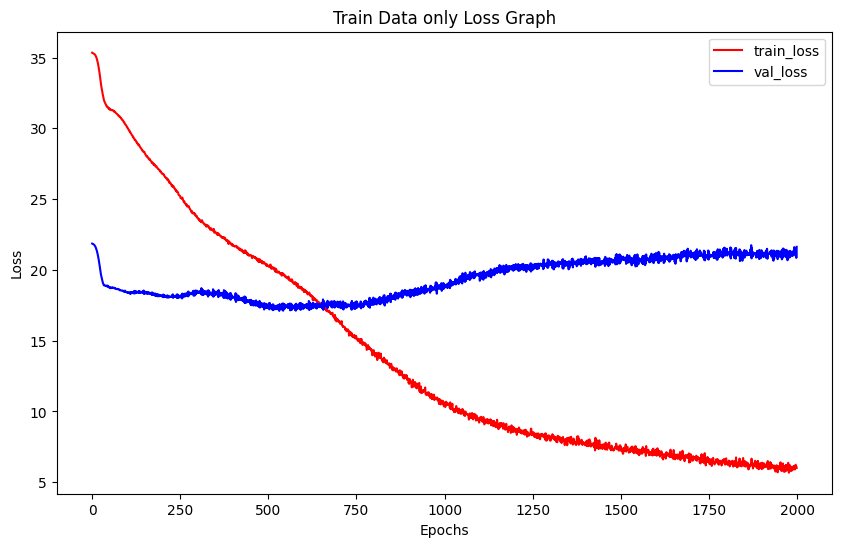

In [ ]:
# 훈련 loss 값 변화
val_loss = history.history['val_loss']
train_loss = history.history['loss']
plt.figure(figsize=(10, 6))

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title('Train Data only Loss Graph')
plt.plot(range(EPOCHS), train_loss, color='r', label='train_loss')
plt.plot(range(EPOCHS), val_loss, color='b', label='val_loss')
plt.legend()

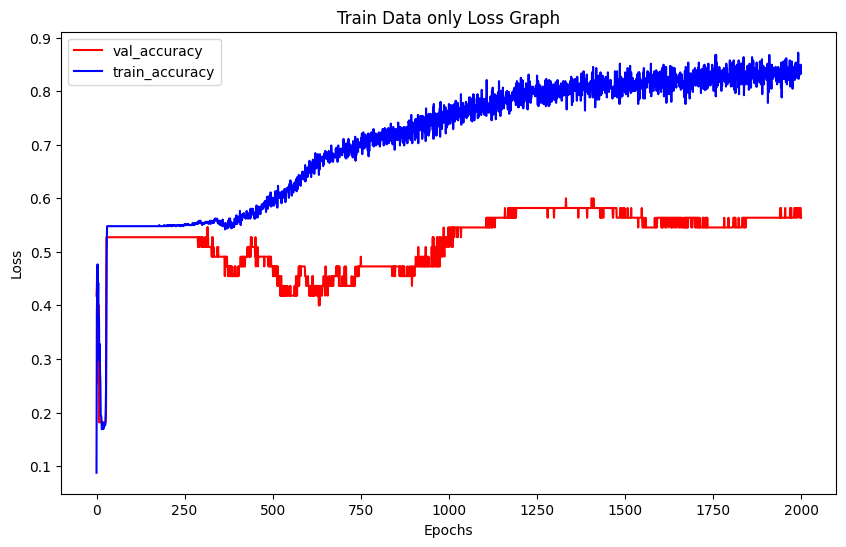

In [ ]:
# 훈련 loss 값 변화
val_accuracy = history.history['val_accuracy']
train_accuracy = history.history['accuracy']
plt.figure(figsize=(10, 6))

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title('Train Data only Loss Graph')
plt.plot(range(EPOCHS), val_accuracy, color='r', label='val_accuracy')
plt.plot(range(EPOCHS), train_accuracy, color='b', label='train_accuracy')
plt.legend()

In [38]:
model.save('./checkpoint/no_sparsity_dnn.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
ing_mapper
int_to_ing = {value: key for key, value in ing_mapper.items()}

In [40]:
def decode_prediction(prediction, index_range):
  start_index = index_range[0]
  end_index = index_range[1]

  ingr_list = []
  label_list = []
  for i in range(start_index, end_index):
    ingr_list.append({})
    label_list.append({})
    element = ingredient_embedding[i]
    for j in range(len(element)):
      if element[j] != 0: # value 0 is padding value
        ingr_list[i-start_index][int_to_ing[element[j]]] = prediction[i][j]
        label_list[i-start_index][int_to_ing[element[j]]] = measurement_embedding[i][j]


  return ingr_list, label_list

In [41]:
result = model.predict(ingredient_embedding[0:3])
decoded, real_value = decode_prediction(result, (0, 3))
print(decoded)
print('--------------------------------------')
print(real_value)

1/1 [==============================] - 0s 99ms/step
[{'creme de cacao': 31.462053, 'vodka': 24.60038}, {'absolut kurant': 13.876089, 'grand marnier': 7.206703, 'chambord raspberry liqueur': 6.3012705, 'midori melon liqueur': 6.014905, 'malibu rum': 5.459984, 'amaretto': 7.217785, 'cranberry juice': 0.07879237, 'pineapple juice': 0.1308336}, {'lager': 454.5378, 'tequila': 37.254818}]
--------------------------------------
[{'creme de cacao': 29.5735, 'vodka': 29.5735}, {'absolut kurant': 14.78675, 'grand marnier': 7.393375, 'chambord raspberry liqueur': 7.393375, 'midori melon liqueur': 7.393375, 'malibu rum': 7.393375, 'amaretto': 7.393375, 'cranberry juice': 14.78675, 'pineapple juice': 7.393375}, {'lager': 473.176, 'tequila': 44.36025}]


In [42]:
unique_ingredient

array(['151 proof rum', '7-up', 'absinthe', 'absolut citron',
       'absolut kurant', 'absolut peppar', 'absolut vodka', 'advocaat',
       'agave syrup', 'ale', 'allspice', 'almond', 'almond flavoring',
       'amaretto', 'angelica root', 'angostura bitters', 'anis', 'anise',
       'anisette', 'aperol', 'apfelkorn', 'apple', 'apple brandy',
       'apple cider', 'apple juice', 'apple schnapps', 'applejack',
       'apricot', 'apricot brandy', 'aquavit', 'asafoetida', 'añejo rum',
       'bacardi limon', "bailey's irish cream", 'baileys irish cream',
       'banana', 'banana liqueur', 'beer', 'benedictine', 'berries',
       'bitter lemon', 'bitters', 'black pepper', 'black sambuca',
       'blackberry brandy', 'blackcurrant cordial', 'blackcurrant squash',
       'blended whiskey', 'blue curacao', 'blueberry schnapps', 'bourbon',
       'brandy', 'brown sugar', 'butter', 'butterscotch schnapps',
       'cachaca', 'campari', 'candy', 'cantaloupe', 'caramel coloring',
       'caramel 

In [43]:
toy_example = [ing_mapper['vodka'], ing_mapper['sugar'], ing_mapper['absolut kurant'], ing_mapper['lime']]
num_ing = len(toy_example)

toy_example = np.array(toy_example).reshape(1, -1)
toy_example = pad_sequences(toy_example, maxlen=12,  padding='post')

toy_result = model.predict(toy_example)

1/1 [==============================] - 0s 20ms/step


In [44]:
p_list = []
for example_index in range(num_ing):
  p_list.append({int_to_ing[toy_example[0][example_index]] : toy_result[0][example_index]})

print(p_list)


[{'vodka': 30.941383}, {'sugar': 16.219213}, {'absolut kurant': 4.040236}, {'lime': 8.279508}]


In [ ]:
train_dic = []
for i in range(len(train_data)):
  train_dic.append([])
  for j in range(len(train_data['Ingredients'][i])):
    train_dic[i].append({train_data['Ingredients'][i][j][0] : train_data['Measures'][i][j][0]})

In [ ]:
train_dic

[[{'creme de cacao': 29.5735}, {'vodka': 29.5735}],
 [{'absolut kurant': 14.78675},
  {'grand marnier': 7.393375},
  {'chambord raspberry liqueur': 7.393375},
  {'midori melon liqueur': 7.393375},
  {'malibu rum': 7.393375},
  {'amaretto': 7.393375},
  {'cranberry juice': 14.78675},
  {'pineapple juice': 7.393375}],
 [{'lager': 473.176}, {'tequila': 44.36025}],
 [{'malibu rum': 14.78675},
  {'light rum': 14.78675},
  {'151 proof rum': 14.78675},
  {'dark creme de cacao': 29.5735},
  {'cointreau': 29.5735},
  {'milk': 88.7205},
  {'coconut liqueur': 29.5735},
  {'vanilla ice-cream': 236.588}],
 [{'dark rum': 44.0},
  {'light rum': 88.0},
  {'vodka': 44.0},
  {'orange juice': 44.0}],
 [{'goldschlager': 14.78675},
  {'jägermeister': 14.78675},
  {'rumple minze': 14.78675},
  {'151 proof rum': 14.78675}],
 [{'151 proof rum': 22.0}, {'wild turkey': 22.0}],
 [{'jack daniels': 9.857833333333332},
  {'johnnie walker': 9.857833333333332},
  {'jim beam': 9.857833333333332}],
 [{'gin': 14.78675},